In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2
from geopy.geocoders import Nominatim
import folium
from folium.plugins import MarkerCluster
from scipy.stats.mstats import ttest_ind
from scipy.stats import wilcoxon 
import math
import numpy as np
from scipy.stats import shapiro 
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
plt.style.use("seaborn")

In [52]:
df = pd.read_excel("final_df_all_yes.xlsx")

Date correction

In [53]:
df.first_activity_time = pd.to_datetime(df.first_activity_time)
df.last_activity_time = pd.to_datetime(df.last_activity_time)

In [54]:
df.columns

Index(['Unnamed: 0', 'artist_name', 'alias', 'email', 'Gender_from_name',
       'Gender_from_alias', 'final_gender', 'address', 'sold', 'N_of_items',
       'worth_in_tezos', 'author_location', 'author_country', 'twitter',
       'description', 'kind', 'bio_ig', 'website', 'balance',
       'author_description_twitter', 'site', 'instagram', 'telegram',
       'facebook', 'reddit', 'github', 'discord', 'first_activity',
       'first_activity_time', 'last_activity', 'last_activity_time'],
      dtype='object')

### Normality test

In [45]:
for t in x.columns:
    print(shapiro(x[t]))

ShapiroResult(statistic=0.2509807348251343, pvalue=0.0)
ShapiroResult(statistic=0.16345053911209106, pvalue=0.0)
ShapiroResult(statistic=0.15409332513809204, pvalue=0.0)
ShapiroResult(statistic=0.13436853885650635, pvalue=0.0)
ShapiroResult(statistic=0.705614447593689, pvalue=0.0)
ShapiroResult(statistic=0.8337863087654114, pvalue=0.0)


Not normal data

### Diversity

In [55]:
df.head()

,Unnamed: 0,artist_name,alias,email,Gender_from_name,Gender_from_alias,final_gender,address,sold,N_of_items,...,instagram,telegram,facebook,reddit,github,discord,first_activity,first_activity_time,last_activity,last_activity_time
0,0,sintang_ligalig,sintang_ligalig,marlon.hacla@gmail.com,unknown,unknown,female,tz2G5SBeAJVbiE1icji3P59Lx8EvcwMLEHp3,507,701,...,NaN,NaN,NaN,NaN,NaN,NaN,1364121,2021-02-28 08:45:09,2622450,2022-08-14 22:42:29
1,1,KOSHA,KOSHA,rkoshino@gmail.com,unknown,unknown,male,tz1ZdMfzmWLb8mu22jE7rZ8Y3t9iKezM68cq,1330,1951,...,koshasnc,NaN,NaN,NaN,NaN,NaN,1340562,2021-02-11 19:46:46,2623436,2022-08-15 06:58:29
2,2,Mario Klingemann,Mario Klingemann,NaN,male,male,male,tz1hb9PiWxQEf6J9xevPsUM6dkuCLnhDMvsp,2967,4447,...,NaN,NaN,NaN,NaN,NaN,NaN,1358622,2021-02-24 12:21:06,2622274,2022-08-14 21:14:29
3,3,Tais Koshino,Tais Koshino,NaN,unknown,unknown,female,tz1U2wsJgebEvS6CZYXn1mjErRU5mSZ2ZS1Z,2118,4772,...,taiskoshino,NaN,NaN,NaN,NaN,NaN,1362035,2021-02-26 21:43:09,2623417,2022-08-15 06:48:59
4,4,Qartsi,Qartsi,quasiartsi@gmail.com,unknown,unknown,male,tz1PYqfNnkpZydtSY2Tn3Rv8mjkgUpHJpFXC,231,296,...,qartsi,NaN,NaN,NaN,NaN,NaN,189154,2018-11-14 23:52:44,2616283,2022-08-12 18:55:14


In [56]:
def get_continent(col):
    try:
        cn_a2_code =  country_name_to_country_alpha2(col)
    except:
        cn_a2_code = 'Unknown' 
    try:
        cn_continent = country_alpha2_to_continent_code(cn_a2_code)
    except:
        cn_continent = 'Unknown' 
    return (cn_a2_code, cn_continent)

In [10]:
codes = []
for t in df["author_location"]:
    codes.append(get_continent(t))


In [11]:
location = df[["alias","author_location"]]
location["codes"]=codes
location[["Country","Continent"]]=pd.DataFrame(location["codes"].tolist(), index=location.index)

<ipython-input-11-dbc5ac110dd7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location["codes"]=codes
<ipython-input-11-dbc5ac110dd7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location[["Country","Continent"]]=pd.DataFrame(location["codes"].tolist(), index=location.index)
<ipython-input-11-dbc5ac110dd7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [11]:
geolocator = Nominatim(user_agent="habibi")
def geolocate(country):
    try:
        loc = geolocator.geocode(country)
        return (loc.latitude, loc.longitude)
    except:
        return np.nan

In [12]:
coordinates = []
for c in location["Country"]:
    coordinates.append(geolocate(c))

In [76]:
location["coordinates"]=coordinates

<ipython-input-76-a4d3f9670b87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location["coordinates"]=coordinates


In [12]:
ind = location[location["Country"]=="Unknown"].index
location.drop(ind, inplace=True)

<ipython-input-12-0da0068e5841>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location.drop(ind, inplace=True)


In [13]:
coun = location[["author_location","codes"]].groupby("author_location").count()
cont = location[["Continent","codes"]].groupby("Continent").count()
def calculate_blau_index(data):
    total_population = data.sum()
    squared_population = data.apply(lambda x: x**2)
    blau_index = squared_population.sum() / (total_population ** 2)
    return blau_index
1-calculate_blau_index(cont["codes"])

0.7321099493122915

In [78]:
location[["Longitude","Latitude"]]=pd.DataFrame(location["coordinates"].tolist(), index=location.index)

<ipython-input-78-25a97975c4b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location[["Longitude","Latitude"]]=pd.DataFrame(location["coordinates"].tolist(), index=location.index)


In [79]:
location.dropna(inplace=True)

<ipython-input-79-8e9d8775c1f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location.dropna(inplace=True)


## Disparity

In [57]:
df.columns

Index(['Unnamed: 0', 'artist_name', 'alias', 'email', 'Gender_from_name',
       'Gender_from_alias', 'final_gender', 'address', 'sold', 'N_of_items',
       'worth_in_tezos', 'author_location', 'author_country', 'twitter',
       'description', 'kind', 'bio_ig', 'website', 'balance',
       'author_description_twitter', 'site', 'instagram', 'telegram',
       'facebook', 'reddit', 'github', 'discord', 'first_activity',
       'first_activity_time', 'last_activity', 'last_activity_time'],
      dtype='object')

In [58]:
disparity = df[['alias','final_gender', 'sold', 'N_of_items', 'worth_in_tezos', 'balance']]

{'whiskers': [<matplotlib.lines.Line2D at 0x27f1ce05d00>,
 'caps': [<matplotlib.lines.Line2D at 0x27f1ce943a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x27f1ce05a30>],
 'medians': [<matplotlib.lines.Line2D at 0x27f1ce94880>],
 'fliers': [<matplotlib.lines.Line2D at 0x27f1ce94b50>],
 'means': []}

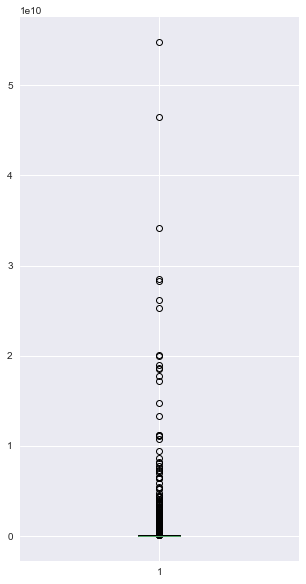

In [59]:
plt.figure(figsize=(5,10))
plt.boxplot(disparity["balance"], showfliers=True, )

In [60]:
print("The median in balance of NFT users: ", disparity.balance.median(),"tz")
print("The average in balance of NFT users: ",disparity.balance.mean(),"tz")
print("Q1: ", np.percentile(disparity.balance, q=25),"tz")
print("Q2: ",np.percentile(disparity.balance, q=75), "tz")

The median in balance of NFT users:  12371902.0 tz
The average in balance of NFT users:  353028057.1754386 tz
Q1:  1871959.5 tz
Q2:  71095741.5 tz


In [61]:
print("Percentage of artists below the average: ", disparity[disparity.balance < 353028057.1754386].balance.count()*100/len(disparity))
print("Percentage of artists above the average: ", disparity[disparity.balance >= 353028057.1754386].balance.count()*100/len(disparity))

Percentage of artists below the average:  89.54248366013071
Percentage of artists above the average:  10.457516339869281


In [62]:
disparity["sales_ratio"] = round(100*disparity['sold']/disparity['N_of_items'],2)

<ipython-input-62-ca5dd5e02346>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disparity["sales_ratio"] = round(100*disparity['sold']/disparity['N_of_items'],2)


(array([24., 21., 27., 31., 21., 29., 27., 14., 13., 26., 24., 31., 16.,
        20., 36., 12., 12., 14., 18., 16.,  4., 12.,  9., 17., 14.,  5.,
        10., 12.,  6., 43.,  9.,  9.,  9., 20.,  7., 11.,  3., 13.,  7.,
        15.,  8., 10., 12., 11., 17.,  6.,  9.,  9., 10., 18.,  4.,  3.,
         9., 16., 15., 12., 11.,  6., 10., 30.,  3.,  4.,  5., 12.,  6.,
         9.,  9.,  9., 10.,  9., 13., 12.,  6.,  8., 24.,  4.,  3.,  7.,
        11., 11.,  5., 11.,  5.,  8.,  3., 11.,  5.,  6.,  6., 13.,  6.,
         8.,  6.,  7.,  8., 11.,  2.,  4.,  8., 30.,  3.,  9.,  7., 12.,
        10.,  8.,  6.,  8.,  7.,  8.,  8.,  7.,  9., 12.,  8., 18.,  5.,
         4.,  9., 24.,  4.,  8.,  9.,  8., 10.,  5.,  9.,  9.,  8.,  6.,
         5., 11.,  9., 13.,  9., 11., 10.,  9., 13.,  8., 10.,  8., 16.,
        13.,  5., 10., 11.,  8.,  7., 35., 11., 13., 15., 12., 17., 14.,
         8., 15.,  9., 14.,  5.,  6., 13., 14., 14.,  9., 12.,  3.,  8.,
         6., 12., 14., 12.,  8.,  7.,  7.,  7., 11.

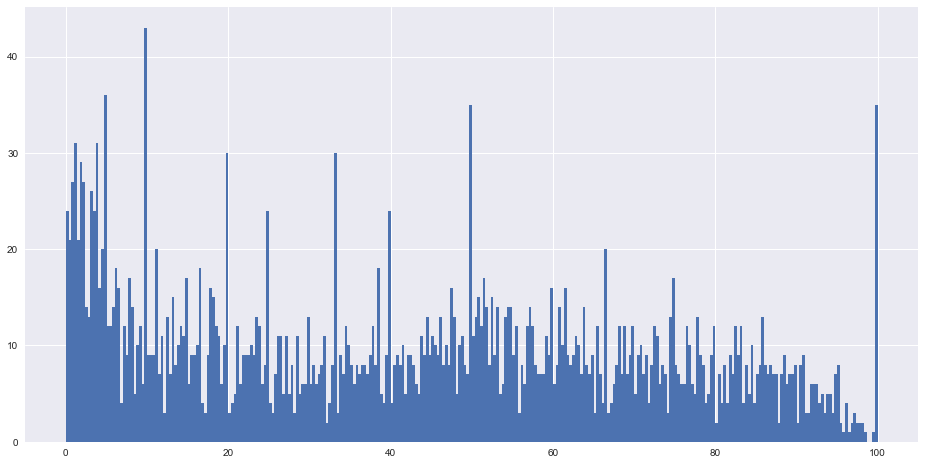

In [63]:
plt.figure(figsize=(16,8))
plt.hist(disparity["sales_ratio"], bins=300)

In [64]:
print("The median of NFTs worth of artists: ", disparity.worth_in_tezos.median(),"tz")
print("The average of NFTs worth of artists: ",disparity.worth_in_tezos.mean(),"tz")
print("Q1: ", np.percentile(disparity.worth_in_tezos, q=25),"tz")
print("Q2: ",np.percentile(disparity.worth_in_tezos, q=75), "tz")

The median of NFTs worth of artists:  19.0 tz
The average of NFTs worth of artists:  164.95778825318192 tz
Q1:  5.0 tz
Q2:  80.25 tz


In [65]:
print("Percentage of artists below the average: ", disparity[disparity.worth_in_tezos < 164.95778825318192].worth_in_tezos.count()*100/len(disparity))
print("Percentage of artists above the average: ", disparity[disparity.worth_in_tezos >= 164.95778825318192].worth_in_tezos.count()*100/len(disparity))

Percentage of artists below the average:  84.6233230134159
Percentage of artists above the average:  15.376676986584107


Text(2930, 650.95, 'Average')

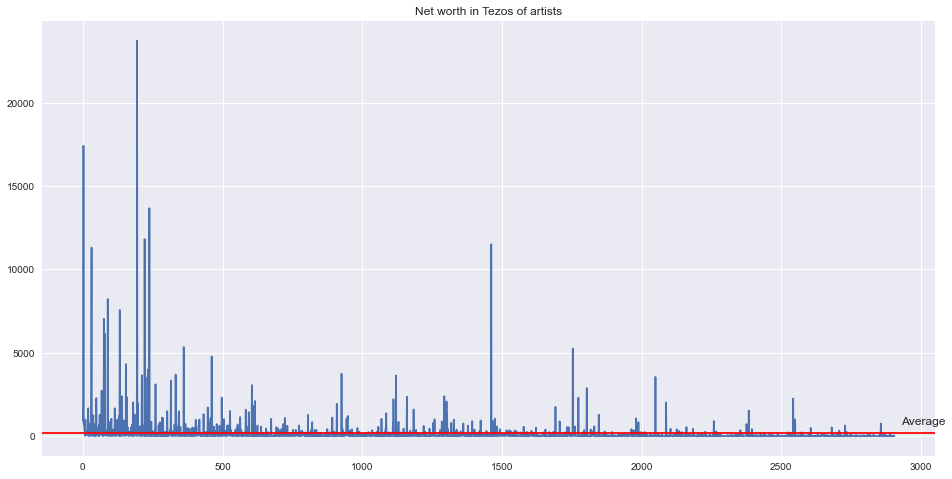

In [66]:
plt.figure(figsize=(16,8))
plt.plot(disparity["worth_in_tezos"])
plt.axhline(164.95, color="red")
plt.title("Net worth in Tezos of artists")
plt.annotate(xy=(2930,650.95), text="Average")

Text(2930, 904128067, 'Average')

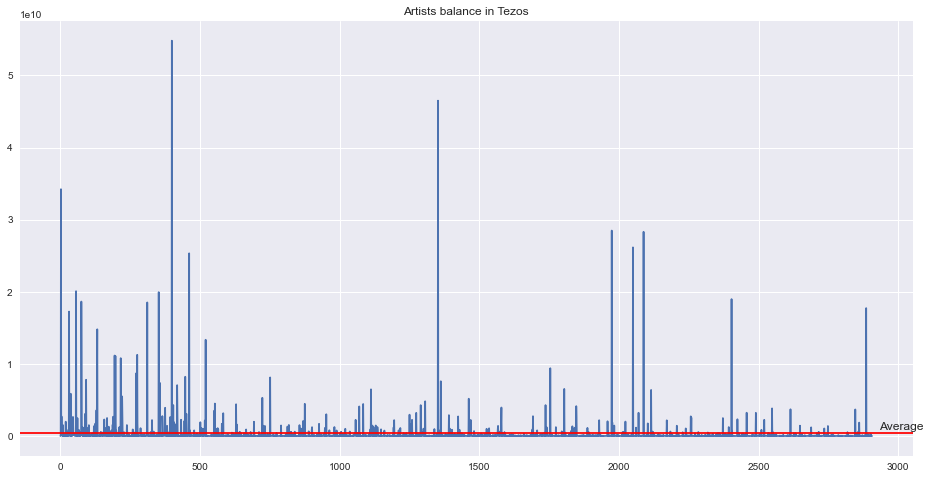

In [67]:
plt.figure(figsize=(16,8))
plt.plot(disparity["balance"])
plt.axhline(353028057.17, color="red")
plt.title("Artists balance in Tezos")
plt.annotate(xy=(2930,904128067), text="Average")

## Gender equality

In [68]:
gender = df[['alias','final_gender', 'sold', 'N_of_items','worth_in_tezos', 'balance']]
gender["sales_ratio"] = round(100*gender['sold']/gender['N_of_items'],2)

<ipython-input-68-7fb19989dfa2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender["sales_ratio"] = round(100*gender['sold']/gender['N_of_items'],2)


In [69]:
print(f"Distribution of males and females: {gender.final_gender.value_counts()}")

Distribution of males and females: male       1662
unknown     677
female      554
other        14
Name: final_gender, dtype: int64


In [70]:
gender.groupby("final_gender").mean().T


final_gender,female,male,other,unknown
sold,2.038881e+02,2.089242e+02,5.435714e+01,1.674801e+02
N_of_items,4.708682e+02,5.932232e+02,1.939286e+02,5.087563e+02
worth_in_tezos,1.531485e+02,1.970100e+02,5.437143e+01,9.822191e+01
balance,3.867906e+08,3.749564e+08,4.009430e+07,2.780379e+08
sales_ratio,4.294563e+01,4.211486e+01,3.947786e+01,4.157344e+01


In [71]:
gender.groupby("final_gender").sum().T

final_gender,female,male,other,unknown
sold,1.129540e+05,3.472320e+05,7.610000e+02,1.133840e+05
N_of_items,2.608610e+05,9.859370e+05,2.715000e+03,3.444280e+05
worth_in_tezos,8.484428e+04,3.274306e+05,7.612000e+02,6.649623e+04
balance,2.142820e+11,6.231776e+11,5.613202e+08,1.882317e+11
sales_ratio,2.379188e+04,6.999490e+04,5.526900e+02,2.814522e+04


In [72]:
gender[gender["final_gender"]=="male"].nlargest(columns=["worth_in_tezos"], n=20)["worth_in_tezos"].sum()/gender["worth_in_tezos"].sum()

0.30256535980765853

In [73]:
print(f"""Percentage of wealth held by males: {100*(gender[gender["final_gender"]=="male"]["worth_in_tezos"].sum()/gender["worth_in_tezos"].sum())}""")
print(f"""Percentage of wealth held by females: {100*(gender[gender["final_gender"]=="female"]["worth_in_tezos"].sum()/gender["worth_in_tezos"].sum())}""")
print("\n")
print(f"""Percentage of total balance held by males: {100*(gender[gender["final_gender"]=="male"]["balance"].sum()/gender["balance"].sum())}""")
print(f"""Percentage of total balance held by females: {100*(gender[gender["final_gender"]=="female"]["balance"].sum()/gender["balance"].sum())}""")

Percentage of wealth held by males: 68.28123631557091
Percentage of wealth held by females: 17.69313155533844


Percentage of total balance held by males: 60.7236100371448
Percentage of total balance held by females: 20.88004265448652


In [74]:
print(f"""The Tezos worth held by the top wealthy males (net worth comparison): 
{gender[gender["final_gender"]=="male"].nlargest(columns=["worth_in_tezos"], n=20)["worth_in_tezos"].sum()}
""")
print("\n")
print(f"""The Tezos worth held by the top wealthy females (net worth comparison): 
{gender[gender["final_gender"]=="female"].nlargest(columns=["worth_in_tezos"], n=20)["worth_in_tezos"].sum()}
""")
print("\n")
print(f"Percentage of wealth held by top 20 wealthy women over top 20 wealthy males: {100*48519.55/(48519.55+145089.86)}")

The Tezos worth held by the top wealthy males (net worth comparison): 
145089.86000000002



The Tezos worth held by the top wealthy females (net worth comparison): 
48519.55



Percentage of wealth held by top 20 wealthy women over top 20 wealthy males: 25.060532956533468


In [75]:
# important
print(f"""Ratio of sold items for males: {gender[gender["final_gender"]=="male"]["sales_ratio"].mean()}""")
print(f"""Ratio of sold items for females: {gender[gender["final_gender"]=="female"]["sales_ratio"].mean()}""")

Ratio of sold items for males: 42.11486161251503
Ratio of sold items for females: 42.94563176895305


In [76]:
gender_num=[]
for t in gender["final_gender"]:
    if t=="female":
        gender_num.append(1)
    elif t=="male":
        gender_num.append(0)
    elif t=="other":
        gender_num.append(2)
    else:
        gender_num.append(3)

In [77]:
gender["gender_num"] = gender_num

<ipython-input-77-612a43705386>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender["gender_num"] = gender_num


In [78]:
print(wilcoxon(gender["gender_num"], gender["worth_in_tezos"]))
print(wilcoxon(gender["gender_num"], gender["balance"]))
print(wilcoxon(gender["gender_num"], gender["sold"]))
print(wilcoxon(gender["gender_num"], gender["N_of_items"]))
print(wilcoxon(gender["gender_num"], gender["sales_ratio"]))

WilcoxonResult(statistic=35599.5, pvalue=0.0)
WilcoxonResult(statistic=3135.0, pvalue=0.0)
WilcoxonResult(statistic=21932.5, pvalue=0.0)
WilcoxonResult(statistic=35.5, pvalue=0.0)
WilcoxonResult(statistic=8081.0, pvalue=0.0)


## Clustering

In [79]:
clustering = df[[ 'alias',
        'sold', 'N_of_items',
       'worth_in_tezos', 'balance', 'first_activity_time', 'last_activity_time']]
clustering["gender"]=gender["gender_num"]
clustering["active_days"] = (clustering['last_activity_time'] - clustering['first_activity_time']) / np.timedelta64(1, 'D')
x=clustering[['sold', 'N_of_items','worth_in_tezos', 'balance', 'gender', 'active_days']].reset_index().drop("index", axis=1)
x

<ipython-input-79-6486b73fbe55>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering["gender"]=gender["gender_num"]
<ipython-input-79-6486b73fbe55>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustering["active_days"] = (clustering['last_activity_time'] - clustering['first_activity_time']) / np.timedelta64(1, 'D')


,sold,N_of_items,worth_in_tezos,balance,gender,active_days
0,507,701,922.00,3519498,1,532.581481
1,1330,1951,1901.98,168246765,0,549.466470
2,2967,4447,17423.30,34221949698,0,536.370405
3,2118,4772,712.04,144861485,1,534.379051
4,231,296,953.77,2722244269,0,1366.793403
...,...,...,...,...,...,...
2902,1,50,1.00,7714985,0,274.385359
2903,1,33,3.00,101927,3,272.826215
2904,2,50,1.60,22310826,1,273.470590
2905,2,20,0.60,303716,0,270.860567


### Standardizing the dataset

In [80]:
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
scaled

,sold,N_of_items,worth_in_tezos,balance,gender,active_days
0,0.499449,0.066089,0.895557,-0.159734,0.082636,1.103028
1,1.827839,0.607132,2.054843,-0.084450,-0.734445,1.287564
2,4.470093,1.687487,20.416076,15.478922,-0.734445,1.144438
3,3.099736,1.828158,0.647181,-0.095137,0.082636,1.122674
4,0.053962,-0.109209,0.933140,1.082790,-0.734445,10.220128
...,...,...,...,...,...,...
2902,-0.317278,-0.215686,-0.193957,-0.157816,-0.734445,-1.718796
2903,-0.317278,-0.223045,-0.191591,-0.161296,1.716797,-1.735836
2904,-0.315663,-0.215686,-0.193247,-0.151146,0.082636,-1.728794
2905,-0.315663,-0.228671,-0.194430,-0.161204,-0.734445,-1.757319


#### Elbow Method

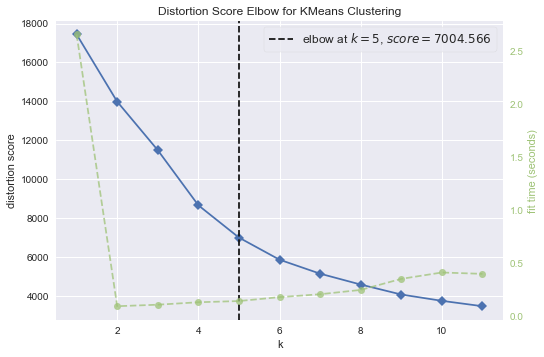

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [81]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(scaled)        
visualizer.show() 

### Dimension reduction

#### PCA

In [36]:
pca=PCA(n_components=2)
reduced = pca.fit_transform(scaled)
red = pd.DataFrame(reduced, columns=["comp1","comp2"])

In [37]:
model = KMeans(n_clusters=5)
model.fit(red)
red["cluster"] = model.labels_
centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

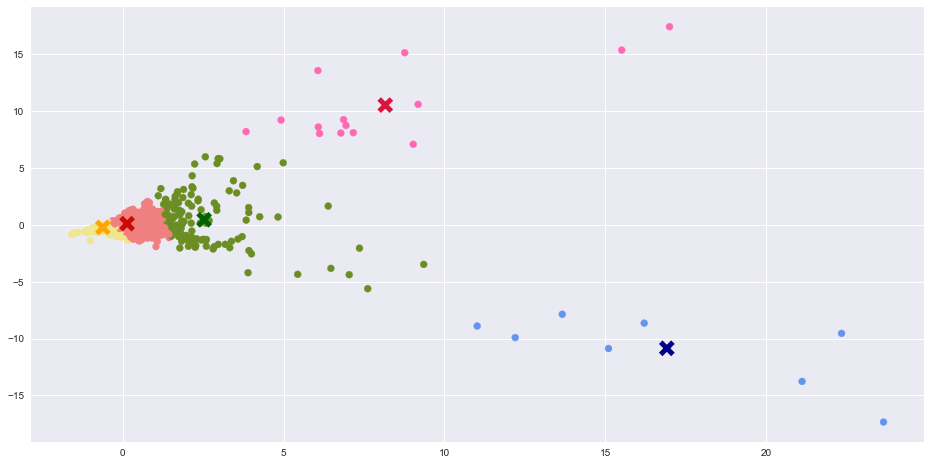

In [38]:
plt.figure(figsize=(16,8))
colors=["lightcoral","cornflowerblue","olivedrab", "khaki", "hotpink"]
plt.scatter(x=red["comp1"],y=red["comp2"], color=[colors[l_] for l_ in model.labels_])
plt.scatter(centroids_x,centroids_y, marker = "x", s=150,linewidths = 5, zorder = 10, c=['r', 'darkblue','darkgreen', "orange","crimson"])

#### Silhouette method

For n_clusters = 2 The average silhouette_score is : 0.9404428986615262
For n_clusters = 3 The average silhouette_score is : 0.9130489769049245
For n_clusters = 4 The average silhouette_score is : 0.6392883402816616
For n_clusters = 5 The average silhouette_score is : 0.4147121623396864
For n_clusters = 6 The average silhouette_score is : 0.41898256191538075


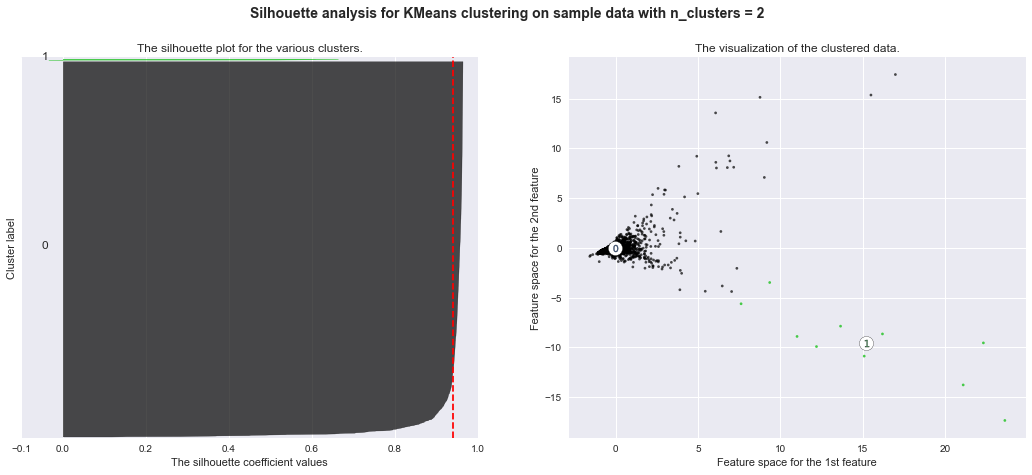

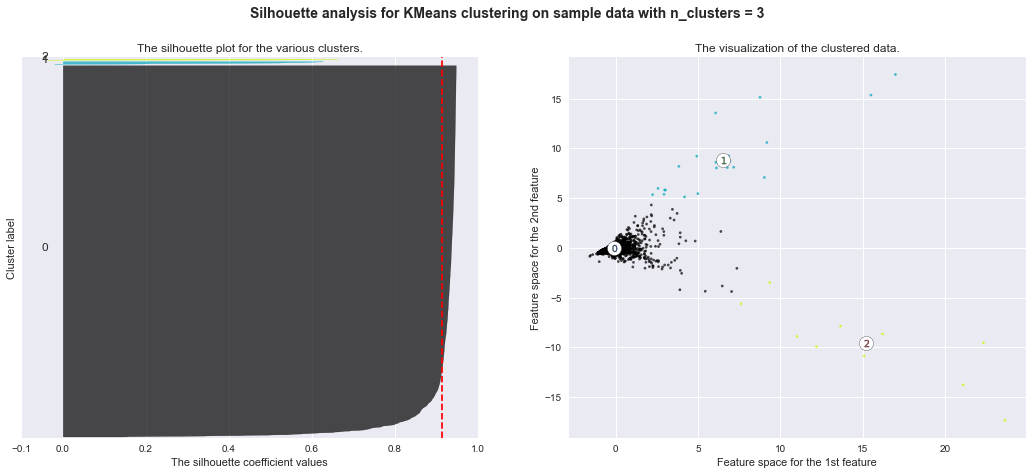

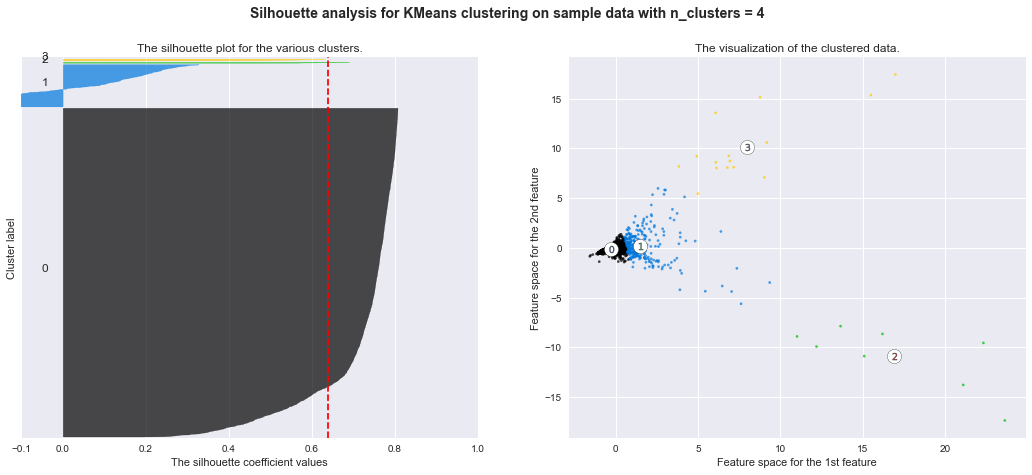

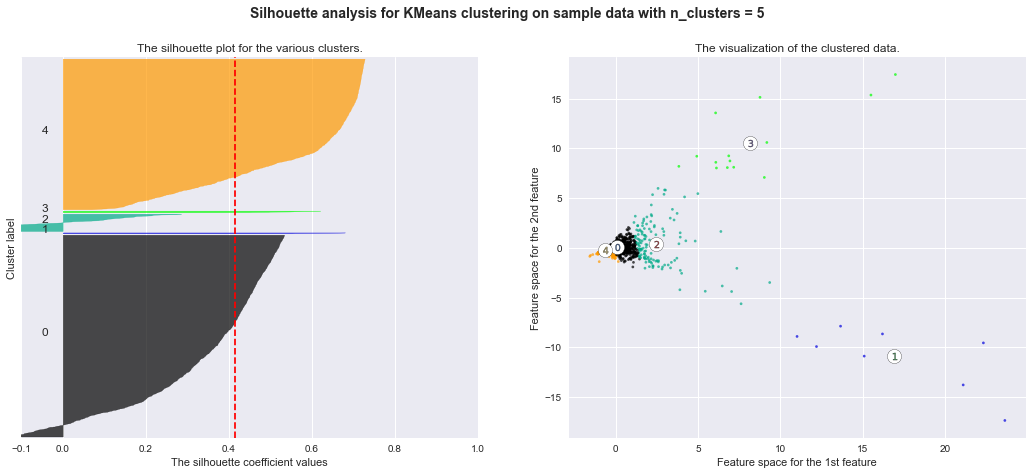

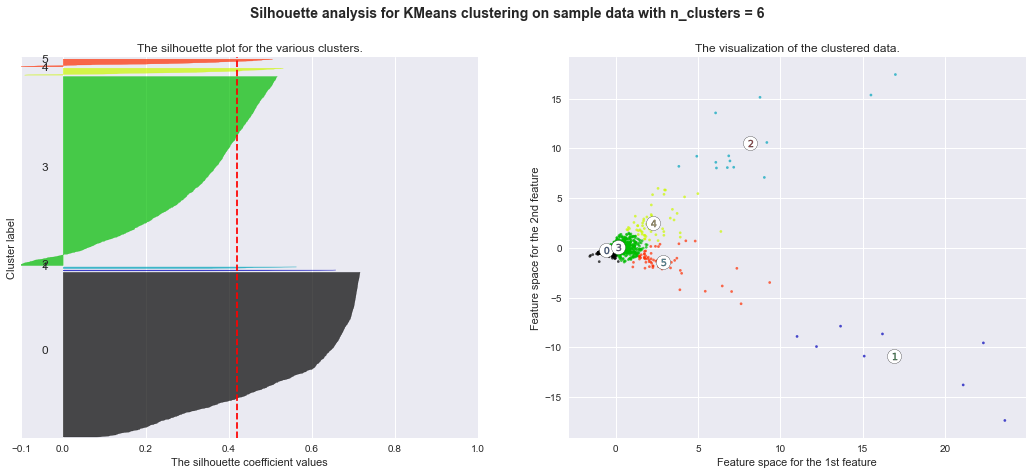

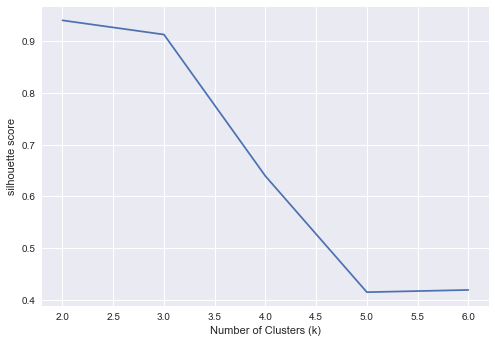

In [39]:

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.cm as cm
import numpy as np
import matplotlib.style as style

range_n_clusters = [2, 3, 4, 5, 6]
silhouette_avg_n_clusters = []

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(reduced) + (n_clusters + 1) * 10])
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(reduced)
    silhouette_avg = silhouette_score(reduced, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    silhouette_avg_n_clusters.append(silhouette_avg)
    sample_silhouette_values = silhouette_samples(reduced, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10 

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced[:, 0], reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')


    centers = clusterer.cluster_centers_

    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


plt.plot(range_n_clusters, silhouette_avg_n_clusters)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("silhouette score")
plt.show()

#### T-sne preparation

In [82]:
from sklearn.manifold import TSNE
red_tsne = pd.DataFrame(TSNE(n_components=2, random_state=69420).fit_transform(scaled),columns=("comp1","comp2"))
red_tsne

c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\farou\anaconda3\envs\myenv\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


,comp1,comp2
0,0.297308,9.297691
1,-7.501758,-3.063431
2,-13.778502,4.214066
3,6.033808,-5.189724
4,-40.153419,-13.747711
...,...,...
2902,69.524063,10.117680
2903,16.081486,59.904747
2904,48.272732,39.479504
2905,69.991692,11.364787


### Clustering with 5

In [83]:
model = KMeans(n_clusters=5)
model.fit(red_tsne)
red_tsne["cluster"] = model.labels_
centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

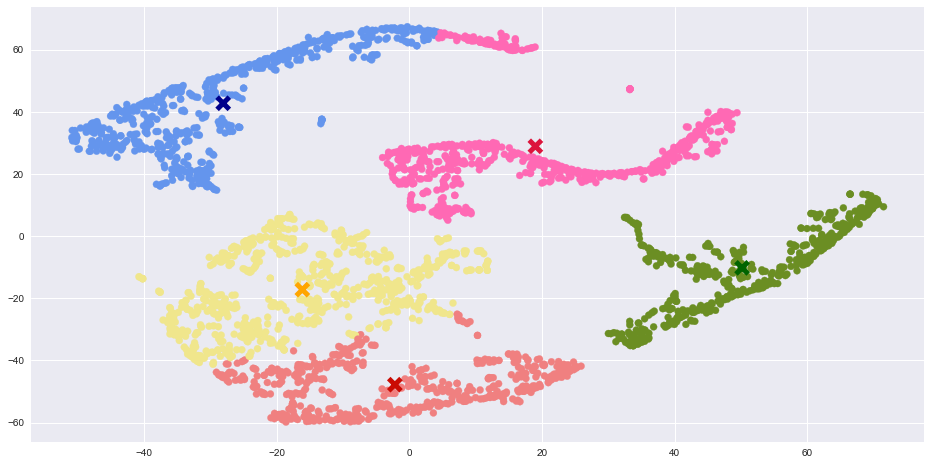

In [84]:
plt.figure(figsize=(16,8))
colors=["lightcoral","cornflowerblue","olivedrab", "khaki", "hotpink"]
plt.scatter(x=red_tsne["comp1"],y=red_tsne["comp2"], color=[colors[l_] for l_ in model.labels_])
plt.scatter(centroids_x,centroids_y, marker = "x", s=150,linewidths = 5, zorder = 10, c=['r', 'darkblue','darkgreen', "orange","crimson"])

#### Clustering with 3

In [85]:
model = KMeans(n_clusters=3)
model.fit(red_tsne)
red_tsne["cluster"] = model.labels_
centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

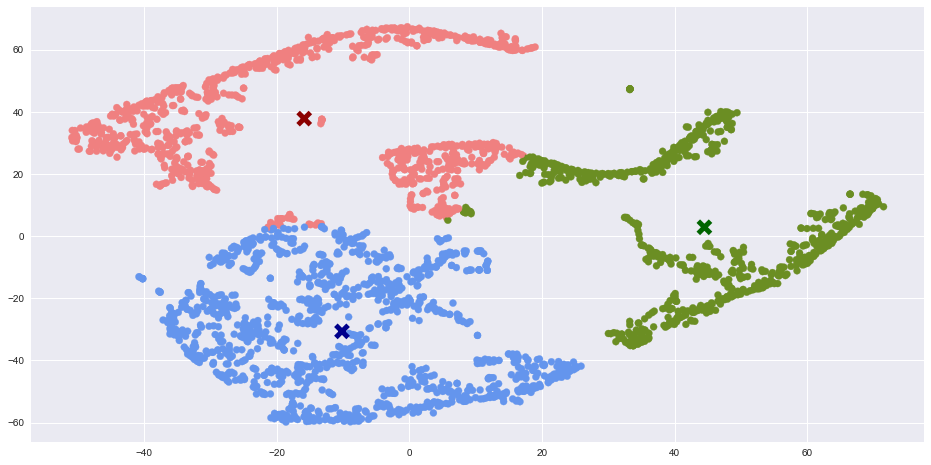

In [86]:
plt.figure(figsize=(16,8))
colors=["lightcoral","cornflowerblue","olivedrab"]
plt.scatter(x=red_tsne["comp1"],y=red_tsne["comp2"], color=[colors[l_] for l_ in model.labels_])
plt.scatter(centroids_x,centroids_y, marker = "x", s=150,linewidths = 5, zorder = 10, c=['darkred', 'darkblue','darkgreen'])


### U-MAP

In [87]:
import umap

In [88]:
reducer = umap.UMAP(n_components=2, random_state=69420)
data_umap = pd.DataFrame(reducer.fit_transform(scaled), columns=("comp1","comp2"))
data_umap

,comp1,comp2
0,3.296695,4.298723
1,7.889883,10.562629
2,7.087325,11.044658
3,8.110547,9.161598
4,9.709861,14.145424
...,...,...
2902,11.793265,-4.504093
2903,-6.181825,-2.388249
2904,4.158131,-6.783497
2905,11.656019,-4.641334


#### Clustering with 5

In [47]:
model = KMeans(n_clusters=5)
model.fit(data_umap[["comp1","comp2"]])
data_umap["cluster"] = model.labels_
centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

In [48]:
centroids

array([[11.679625  , 12.159148  ],
       [ 2.9108903 , -1.2577868 ],
       [-3.9126878 , 10.375172  ],
       [14.293943  ,  0.02834606],
       [-6.416349  ,  3.944986  ]], dtype=float32)

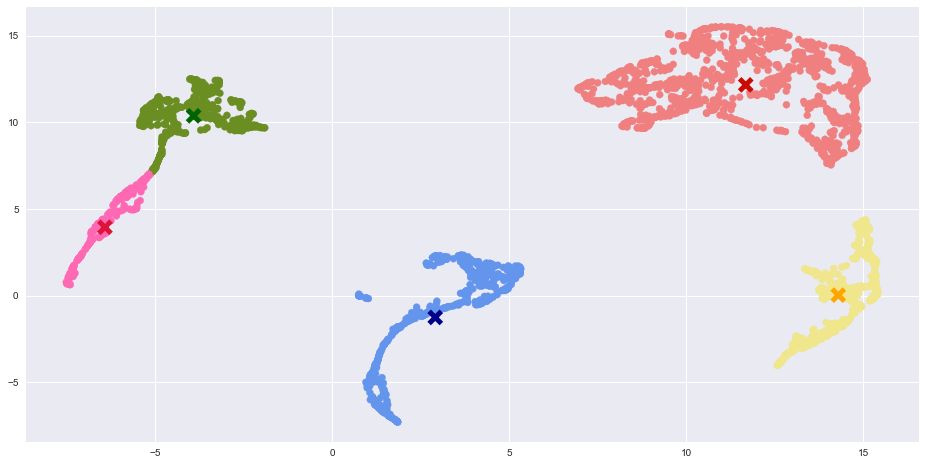

In [49]:
plt.figure(figsize=(16,8))
colors=["lightcoral","cornflowerblue","olivedrab", "khaki", "hotpink"]
plt.scatter(x=data_umap["comp1"],y=data_umap["comp2"], color=[colors[l_] for l_ in model.labels_])
plt.scatter(centroids_x,centroids_y, marker = "x", s=150,linewidths = 5, zorder = 10, c=['r', 'darkblue','darkgreen', "orange","crimson"])

#### Clustering with 3

In [89]:
model = KMeans(n_clusters=3)
model.fit(data_umap[["comp1","comp2"]])
data_umap["cluster"] = model.labels_
centroids = model.cluster_centers_
centroids_x = centroids[:,0]
centroids_y = centroids[:,1]

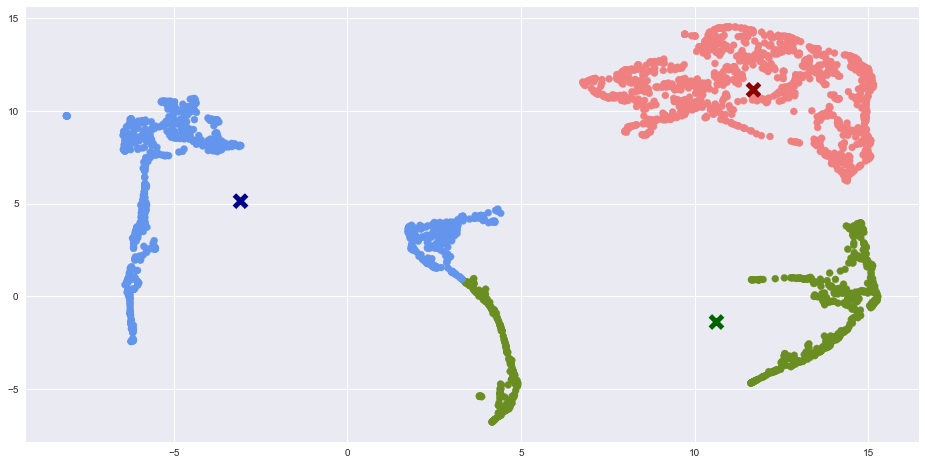

In [90]:
plt.figure(figsize=(16,8))
colors=["lightcoral","cornflowerblue","olivedrab"]
plt.scatter(x=data_umap["comp1"],y=data_umap["comp2"], color=[colors[l_] for l_ in model.labels_])
plt.scatter(centroids_x,centroids_y, marker = "x", s=150,linewidths = 5, zorder = 10, c=['darkred', 'darkblue','darkgreen'])


#### Davies-Bouldin score

Text(0, 0.5, 'Davies Bouldin score')

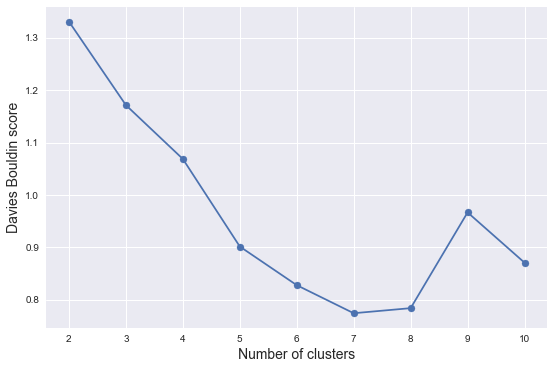

In [84]:
from sklearn.metrics import davies_bouldin_score
ran=list(range(2,11))
db_score=[]
for i in range(2,11):
    kmeans = KMeans(n_clusters=i, random_state=69420)
    labels = kmeans.fit_predict(scaled)
    db_index = davies_bouldin_score(scaled, labels)
    db_score.append(db_index)

plt.scatter(x=np.array(ran), y=np.array(db_score))
plt.plot(ran, db_score)
plt.xlabel("Number of clusters", fontsize="14")
plt.ylabel("Davies Bouldin score", fontsize="14")

In [80]:
from sklearn.metrics import davies_bouldin_score
kmeans = KMeans(n_clusters=3)
labels = kmeans.fit_predict(scaled)
db_index = davies_bouldin_score(scaled, labels)
print(db_index)

1.295390146019668


### Comparaison of the two suggested cluster numbers

In [91]:
clus_3 = x.copy()
clus_3["alias"] = clustering["alias"]
kmeans_3 = KMeans(n_clusters=3)
kmeans_3.fit(scaled)
labels_3 = kmeans_3.labels_
clus_3["cluster_3"]=labels_3

In [604]:
clus_5 = x.copy()
clus_5["alias"] = clustering["alias"]
kmeans_5 = KMeans(n_clusters=5)
kmeans_5.fit(scaled)
labels_5 = kmeans_5.labels_
clus_5["cluster_5"]=labels_5

In [92]:
cols=["sold","N_of_items","worth_in_tezos","balance","active_days"]

In [93]:
clus_3[clus_3["cluster_3"]==0].describe(percentiles=[])[cols] # majority of artists with lower of active days than other clusters on average

,sold,N_of_items,worth_in_tezos,balance,active_days
count,2878.000000,2878.000000,2878.000000,2.878000e+03,2878.000000
mean,170.542043,446.761640,118.578082,2.085503e+08,430.820569
std,333.301298,1193.201748,363.522512,8.156197e+08,91.374716
min,1.000000,1.000000,0.010000,0.000000e+00,41.568947
50%,53.000000,154.000000,18.550000,1.211500e+07,468.664132
max,5682.000000,31083.000000,6154.500000,1.334710e+10,1366.793403


In [94]:
clus_3[clus_3["cluster_3"]==1].describe(percentiles=[])[cols] # high number of sales with normal balance and owned items and average number of active days

,sold,N_of_items,worth_in_tezos,balance,active_days
count,8.000000,8.00000,8.000000,8.000000e+00,8.000000
mean,8552.750000,35450.87500,1145.812500,5.575849e+07,497.271314
std,5585.440966,15106.92936,2039.220744,9.439397e+07,52.394258
min,9.000000,20899.00000,3.370000,8.780200e+04,371.783148
50%,10094.500000,28956.50000,18.265000,7.440766e+06,515.443987
max,16066.000000,60155.00000,5822.350000,2.588461e+08,529.578819


In [95]:
clus_3[clus_3["cluster_3"]==2].describe(percentiles=[])[cols]# high number balance and worth and normal number of sales

,sold,N_of_items,worth_in_tezos,balance,active_days
count,21.00000,21.000000,21.000000,2.100000e+01,21.000000
mean,718.52381,1169.238095,6147.527143,2.026660e+10,520.975400
std,760.21455,1411.950137,6717.497264,1.344503e+10,68.454165
min,5.00000,9.000000,2.000000,1.520832e+09,444.737639
50%,468.00000,689.000000,4775.000000,1.864165e+10,520.362789
max,2967.00000,5403.000000,23735.000000,5.481141e+10,799.733125


In [642]:
clus_5[clus_5["cluster_5"]==0].describe(percentiles=[])[cols] # big mass, big number of active days, average balance and sales and actuve days

,sold,N_of_items,worth_in_tezos,balance,active_days
count,1192.00000,1192.000000,1192.000000,1.192000e+03,1192.000000
mean,257.64094,591.864933,204.212787,3.698275e+08,490.979264
std,414.59058,1110.060158,487.039019,1.133226e+09,59.502717
min,1.00000,1.000000,0.020000,0.000000e+00,391.170521
50%,109.00000,253.000000,44.925000,3.100191e+07,491.717604
max,5348.00000,14506.000000,6154.500000,1.334710e+10,1366.793403


In [643]:
clus_5[clus_5["cluster_5"]==1].describe(percentiles=[])[cols] # mid sales mid balance and mid number of active days, but low worth in tezos

,sold,N_of_items,worth_in_tezos,balance,active_days
count,969.000000,969.000000,969.000000,9.690000e+02,969.000000
mean,137.031992,367.113519,76.303399,1.506678e+08,438.905155
std,285.876028,1019.488726,255.170091,5.766510e+08,74.242594
min,1.000000,1.000000,0.010000,1.000000e+00,239.551412
50%,45.000000,134.000000,15.800000,1.289897e+07,470.589537
max,5682.000000,20959.000000,3742.500000,1.079588e+10,731.361887


In [644]:
clus_5[clus_5["cluster_5"]==2].describe(percentiles=[])[cols] # hugh number of sales of owned items and active days

,sold,N_of_items,worth_in_tezos,balance,active_days
count,9.000000,9.000000,9.000000,9.000000e+00,9.000000
mean,7612.444444,34965.555556,1463.198889,5.227886e+07,502.512737
std,5937.598654,14206.045017,2131.953486,8.891239e+07,51.471022
min,9.000000,20899.000000,3.370000,8.780200e+04,371.783148
50%,10025.000000,31083.000000,20.110000,1.110216e+07,520.233160
max,16066.000000,60155.000000,5822.350000,2.588461e+08,544.444120


In [645]:
clus_5[clus_5["cluster_5"]==3].describe(percentiles=[])[cols] # low sales and balance and worth in tezos

,sold,N_of_items,worth_in_tezos,balance,active_days
count,716.000000,716.000000,716.000000,7.160000e+02,716.000000
mean,71.002793,270.196927,27.801389,1.864806e+07,319.568123
std,161.064344,938.857544,66.830679,5.801455e+07,41.247372
min,1.000000,1.000000,0.010000,1.000000e+00,41.568947
50%,12.000000,82.000000,8.250000,3.768168e+06,311.214711
max,1521.000000,20109.000000,1104.350000,6.554250e+08,409.484051


In [646]:
clus_5[clus_5["cluster_5"]==4].describe(percentiles=[])[cols] # high number of active days and worth and balance in tezos 

,sold,N_of_items,worth_in_tezos,balance,active_days
count,21.00000,21.000000,21.000000,2.100000e+01,21.000000
mean,718.52381,1169.238095,6147.527143,2.026660e+10,520.975400
std,760.21455,1411.950137,6717.497264,1.344503e+10,68.454165
min,5.00000,9.000000,2.000000,1.520832e+09,444.737639
50%,468.00000,689.000000,4775.000000,1.864165e+10,520.362789
max,2967.00000,5403.000000,23735.000000,5.481141e+10,799.733125
